![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/80.1.Augmenting_NER_With_Wikidata.ipynb)

# Integrate Wikidata in Spark NLP for Finance
In this notebook, we will guide you to the process of get data from Wikidata SparQL service and store it in a ChunkMapper, so that you can get that information at scale inside Finance NLP.

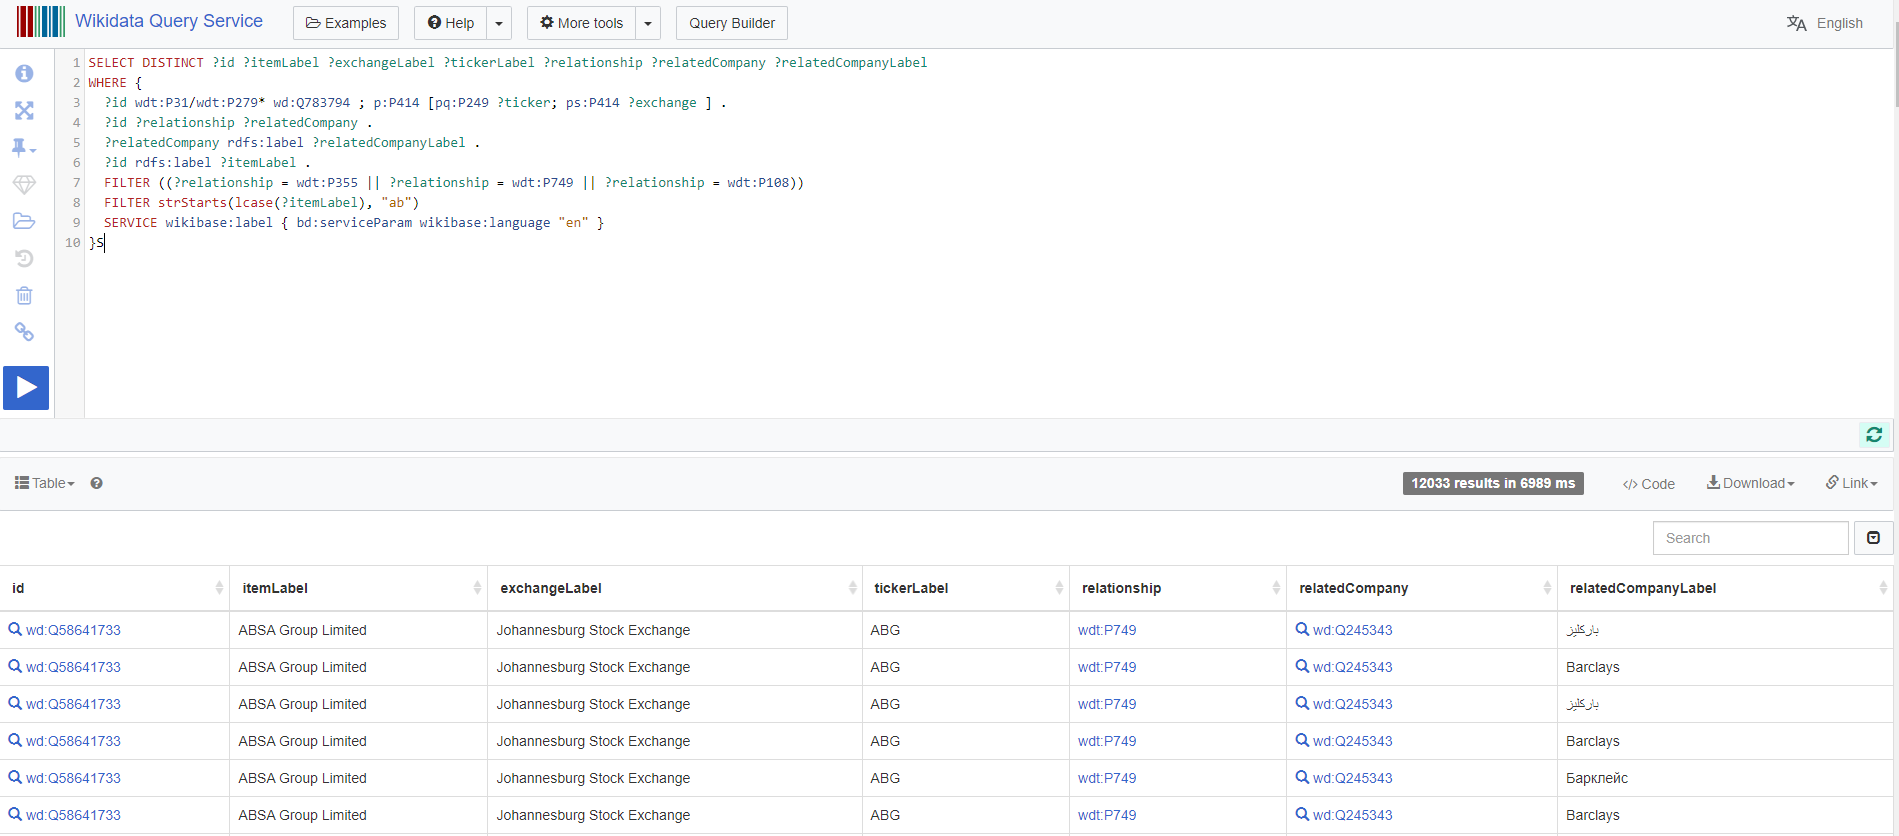

# Installation

In [ ]:
! pip install -q johnsnowlabs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.6/570.6 KB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.9 MB/s eta 0:00:00


## Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, legal

# nlp.install(force_browser=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

Please Upload your John Snow Labs License using the button below


Saving 4.2.8.json to 4.2.8.json


- Install it

In [ ]:
nlp.install()

👌 Detected license file /content/4.2.8.json
📋 Stored John Snow Labs License in /root/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
👷 Setting up  John Snow Labs home in /root/.johnsnowlabs, this might take a few minutes.
🙆 JSL Home setup in /root/.johnsnowlabs
👌 Detected license file /content/4.2.8.json
Installing /root/.johnsnowlabs/py_installs/spark_nlp_jsl-4.2.8-py3-none-any.whl to /usr/bin/python3
Installed 1 products:
💊 Spark-Healthcare==4.2.8 installed! ✅ Heal the planet with NLP! 


# Starting

In [ ]:
spark = nlp.start()

👌 Detected license file /content/4.2.8.json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.2.8, 💊Spark-Healthcare==4.2.8, running on ⚡ PySpark==3.1.2


# Wikidata and SparQL
You probably know Wikipedia is built on top of one of the biggest ontologies, Wikidata.

Wikidata is based on triplets (subject, relation/verb, object), and it can be queried using [SparQL](https://en.wikipedia.org/wiki/SPARQL) (a triplets - RDF - OWL query language). 

Don't confuse SparQL (the Query Language for ontologies) with Spark NLP.

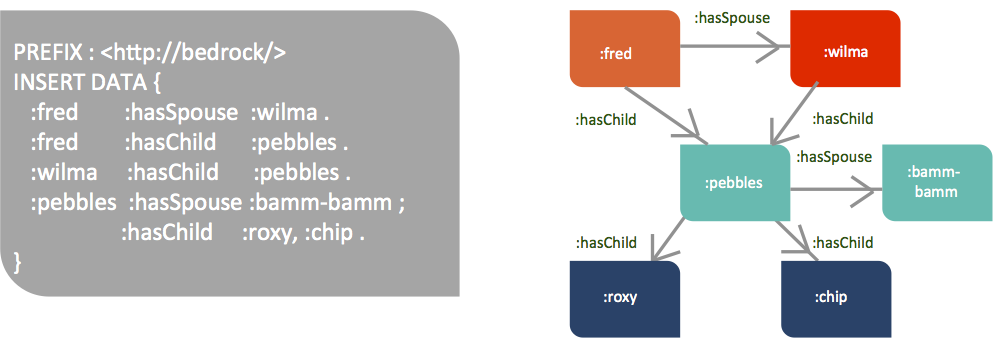

The aim of this notebook is not to teach you SparQL (to do that, you can use resources as [W3.org tutorial](https://www.w3.org/TR/rdf-sparql-query/)), but how to integrate the data you get with your SparQL queries on Wikidata into Finance NLP. 

## The query
For this example, we are going to ask in Wikidata for:
- Instances in Wikidata of companies `(wd:Q783794`)...
- ... which are parent companies of other companies (`?relationship = wdt:P355 || ?relationship = wdt:P749 || ?relationship = wdt:P108`)... 
- ... which have a Stock Exchange and a Ticker symbol (`[pq:P249 ?ticker; ps:P414 ?exchange ]`)...
- ... in English (`SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }`)
- ... with both companies (parent and subsidiary) with labels in English (`   FILTER (lang(?itemLabel) = 'en')
  FILTER (lang(?relatedCompanyLabel) = 'en')`)
- We will limit the results to 100 (`LIMIT 100`)
- And select the ids, labels, and the specific relation of both companies (`SELECT DISTINCT ?id ?itemLabel ?exchangeLabel ?tickerLabel ?relationship ?relatedCompany ?relatedCompanyLabel`)

This is the resulting query:

```
SELECT DISTINCT ?id ?itemLabel ?exchangeLabel ?tickerLabel ?relationship ?relatedCompany ?relatedCompanyLabel
WHERE {
  ?id wdt:P31/wdt:P279* wd:Q783794 ; p:P414 [pq:P249 ?ticker; ps:P414 ?exchange ] .
  ?id ?relationship ?relatedCompany .
  ?relatedCompany rdfs:label ?relatedCompanyLabel .
  ?id rdfs:label ?itemLabel .
  FILTER ((?relationship = wdt:P355 || ?relationship = wdt:P749 || ?relationship = wdt:P108))
  FILTER (lang(?itemLabel) = 'en')
  FILTER (lang(?relatedCompanyLabel) = 'en')
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
LIMIT 100
```


If you run this query in the Wikidata SparQL service, you can visualize the results in many different ways, including tables, graphs, charts...


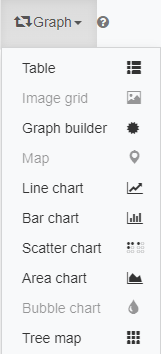

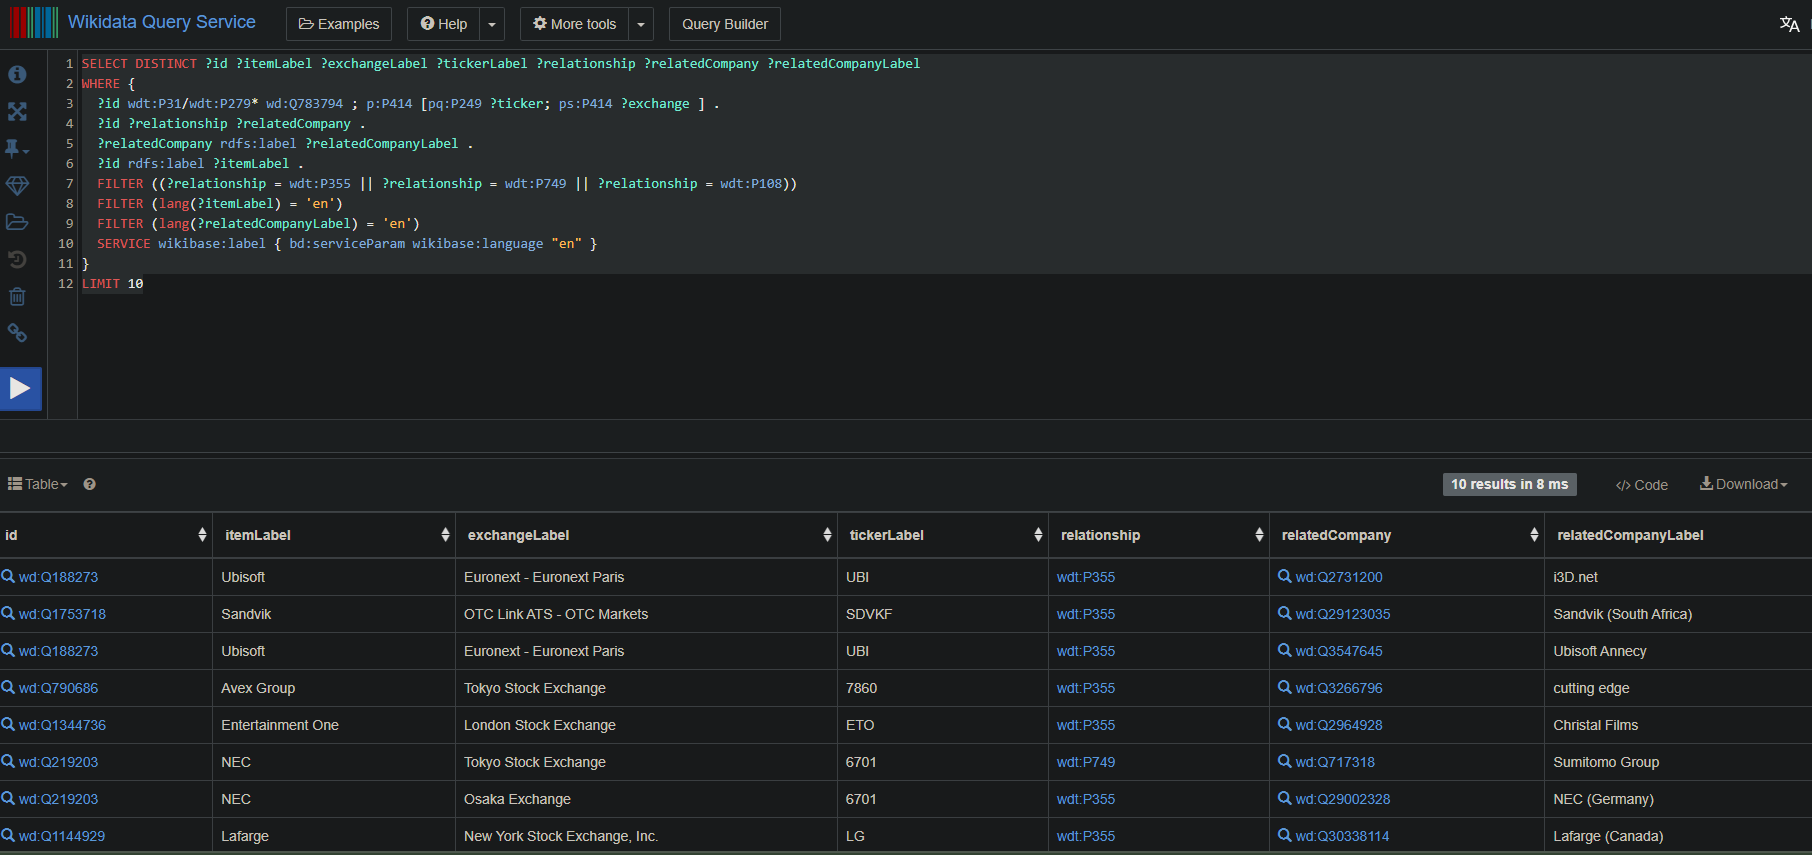

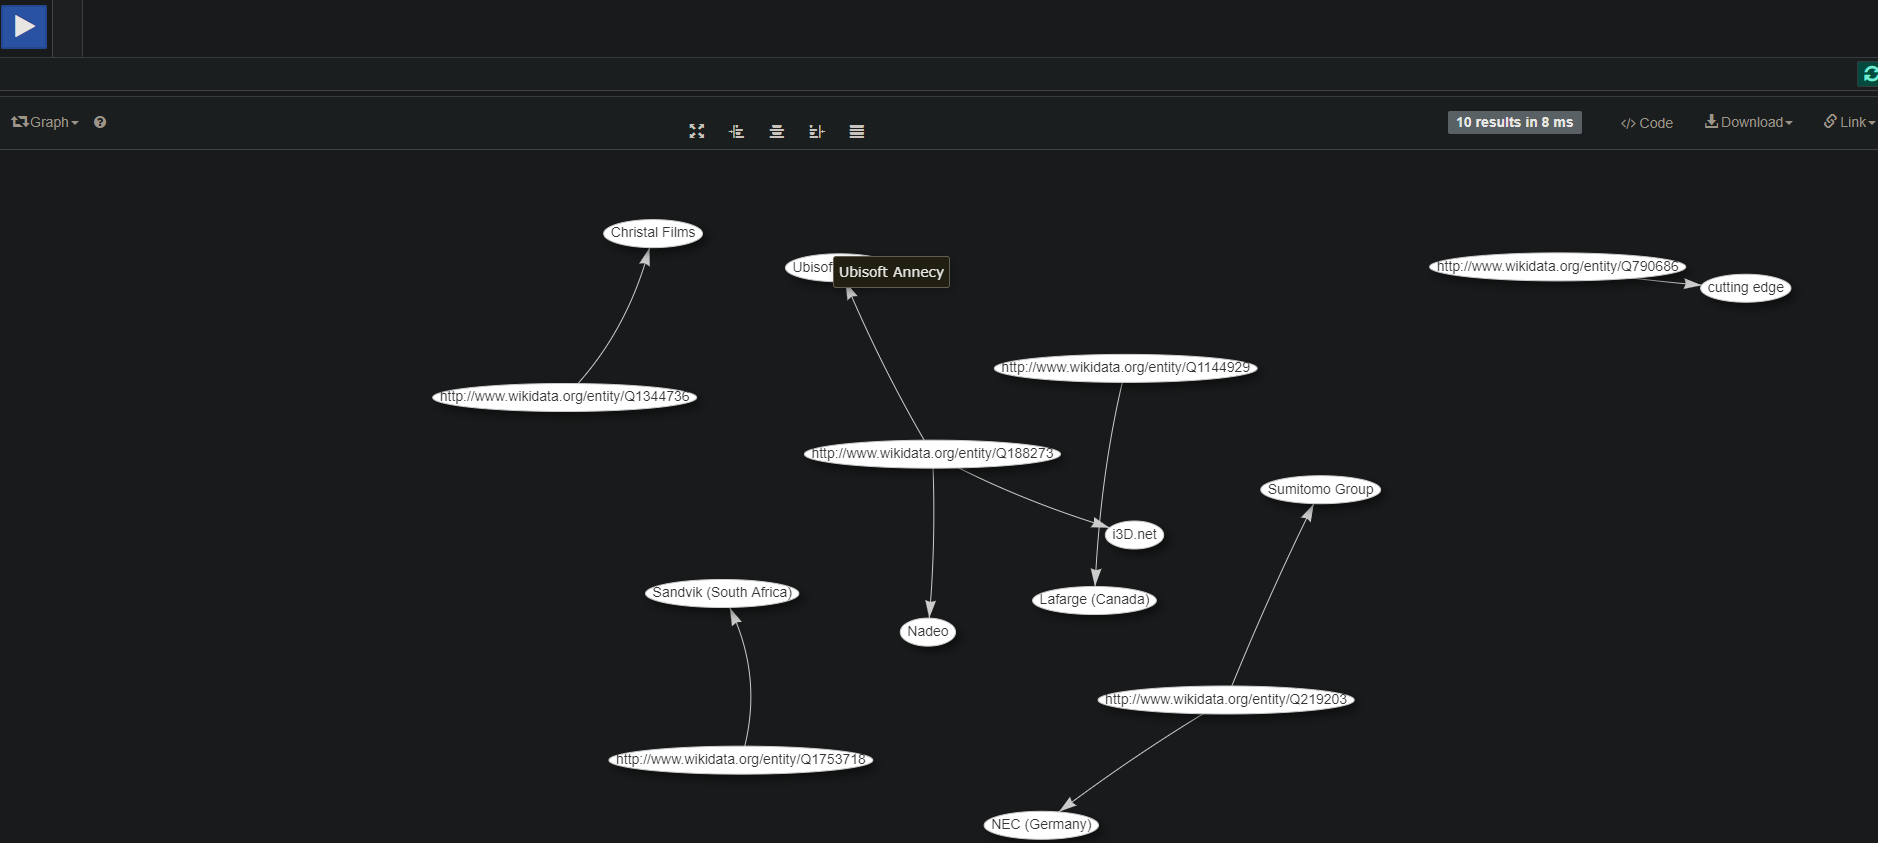

# Getting the data
There are two ways you can access the results:

1) Directly from the service, and clicking on `Download`


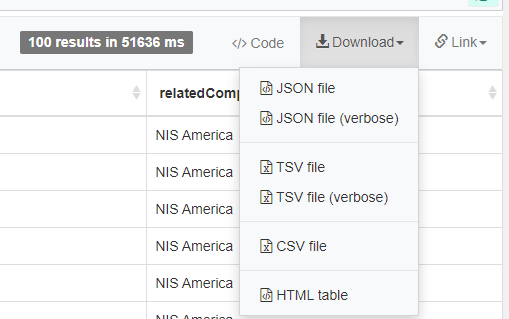

2) Programatically, clicking on `Code`. 

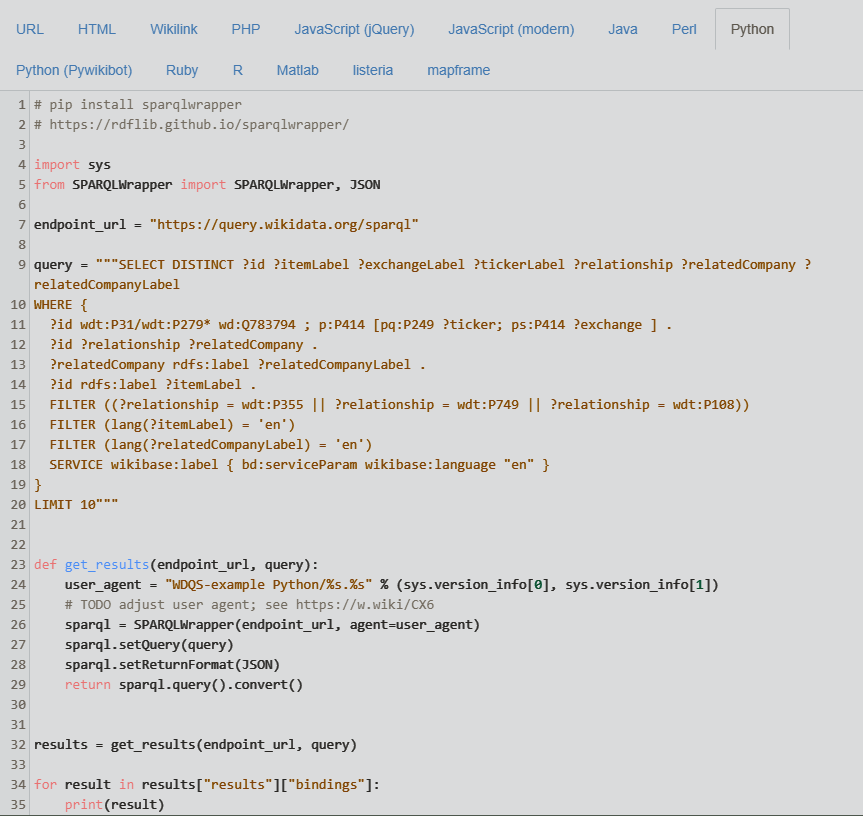

It even automatically puts the query you are inspecting in the code, so that you only copy/paste the code and retrieve the results.

# Let's copy/paste the code and try it!

In [ ]:
!pip install sparqlwrapper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.3/500.3 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 3.0 MB/s eta 0:00:00


In [ ]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import json

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT DISTINCT ?id ?itemLabel ?exchangeLabel ?tickerLabel ?relationship ?relatedCompany ?relatedCompanyLabel
WHERE {
  ?id wdt:P31/wdt:P279* wd:Q783794 ; p:P414 [pq:P249 ?ticker; ps:P414 ?exchange ] .
  ?id ?relationship ?relatedCompany .
  ?relatedCompany rdfs:label ?relatedCompanyLabel .
  ?id rdfs:label ?itemLabel .
  FILTER ((?relationship = wdt:P355 || ?relationship = wdt:P749 || ?relationship = wdt:P108))
  FILTER (lang(?itemLabel) = 'en')
  FILTER (lang(?relatedCompanyLabel) = 'en')
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
LIMIT 100"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    print(result)

{'id': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q1144929'}, 'itemLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Lafarge'}, 'relationship': {'type': 'uri', 'value': 'http://www.wikidata.org/prop/direct/P355'}, 'relatedCompany': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q16995829'}, 'relatedCompanyLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Lafarge Tarmac'}, 'exchangeLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Euronext'}, 'tickerLabel': {'type': 'literal', 'value': 'LG'}}
{'id': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q790686'}, 'itemLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Avex Group'}, 'relationship': {'type': 'uri', 'value': 'http://www.wikidata.org/prop/direct/P355'}, 'relatedCompany': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q3266796'}, 'relatedCompanyLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'cutting edge'}, 'exchangeLabel': {'xml:lang': 'en', 'type': 'litera

In [ ]:
with open('results.json', 'w') as f:
  json.dump(results['results']['bindings'], f)


# It works!
Ok, now we need to transform to the format of Chunk Mappers, which is our Finance NLP Annotator allowing us to store data and map it to, for example, NER entities we have extracted.

In [ ]:
with open('results.json', 'r') as f:
  company_json = json.load(f)

In [ ]:
company_json[:5]

[{'id': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q1144929'},
  'itemLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Lafarge'},
  'relationship': {'type': 'uri',
   'value': 'http://www.wikidata.org/prop/direct/P355'},
  'relatedCompany': {'type': 'uri',
   'value': 'http://www.wikidata.org/entity/Q16995829'},
  'relatedCompanyLabel': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'Lafarge Tarmac'},
  'exchangeLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Euronext'},
  'tickerLabel': {'type': 'literal', 'value': 'LG'}},
 {'id': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q790686'},
  'itemLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Avex Group'},
  'relationship': {'type': 'uri',
   'value': 'http://www.wikidata.org/prop/direct/P355'},
  'relatedCompany': {'type': 'uri',
   'value': 'http://www.wikidata.org/entity/Q3266796'},
  'relatedCompanyLabel': {'xml:lang': 'en',
   'type': 'literal',
   'value': 'cutting edge'},
  'e

ChunkMappers need an array of dictionaries.

Each position in the array will be a company. A position in the array should have a `key` and `relations`.

The `key` will be the name of a company. And the relations, a series of `has_` relations as `has_ticker`, `has_stock_exchange`, etc., including all the subsidiary/other companies it's parent of.

In [ ]:
data_for_chunkmapper = {'mappings': []}

for t in company_json:

  org = t['itemLabel']['value']

  c_dict = dict()
  c_dict['key'] = org
  c_dict['relations'] = list()

  #Let's add the relations!
  # First, we keep the URI to link the ORG to wikidata
  uri = t['id']['value']
  c_dict['relations'].append({'key': 'has_uri', 'values': [uri]})
  # Then, language
  lan = t['itemLabel']['xml:lang']
  c_dict['relations'].append({'key': 'has_language', 'values': [lan]})
  # Then, ticker
  ticker = t['tickerLabel']['value']
  c_dict['relations'].append({'key': 'has_ticker', 'values': [ticker]})
  # Then, Stock Exchange
  exchange = t['exchangeLabel']['value']
  c_dict['relations'].append({'key': 'has_exchange', 'values': [exchange]})
  # The related Company Label
  rcl = t['relatedCompanyLabel']['value']
  c_dict['relations'].append({'key': 'related_company', 'values': [rcl]})
  
  # Let's add the dictionary to our array for training the ChunkMapper
  data_for_chunkmapper['mappings'].append(c_dict)
  

# In case several rows are returned...
Wikidata may return many rows per ORG. For example, imagine several subsidiaries of one company.

Here you will find the code to merge all the subsidiaries in 1 entry (required by the ChunkMapper to be unique).


In [ ]:
data_for_chunkmapper = {'mappings': []}

for t in company_json:

  org = t['itemLabel']['value']

  # Is the entry for ORG new?
  entry = next(filter(lambda x: x['key'] == org, data_for_chunkmapper['mappings']), None)

  if entry is None:
    c_dict = dict()
    c_dict['key'] = org
    c_dict['relations'] = list()

    #Let's add the relations!
    # First, we keep the URI to link the ORG to wikidata
    uri = t['id']['value']
    c_dict['relations'].append({'key': 'has_uri', 'values': [uri]})
    # Then, language
    lan = t['itemLabel']['xml:lang']
    c_dict['relations'].append({'key': 'has_language', 'values': [lan]})
    # Then, ticker
    ticker = t['tickerLabel']['value']
    c_dict['relations'].append({'key': 'has_ticker', 'values': [ticker]})
    # Then, Stock Exchange
    exchange = t['exchangeLabel']['value']
    c_dict['relations'].append({'key': 'has_exchange', 'values': [exchange]})
    # The related Company Label
    rcl = t['relatedCompanyLabel']['value']
    c_dict['relations'].append({'key': 'has_related_company_label', 'values': [rcl]})
    # Let's add the dictionary to our array for training the ChunkMapper
    data_for_chunkmapper['mappings'].append(c_dict)
  else:
    # The company entry exists, I just add a new related company
    rcu = t['relatedCompany']['value']

    for r in entry['relations']:
      if r['key'] == 'has_related_company_label':
        if rcl not in r['values']:
          r['values'].append(rcl)
  
  

In [ ]:
data_for_chunkmapper

{'mappings': [{'key': 'Lafarge',
   'relations': [{'key': 'has_uri',
     'values': ['http://www.wikidata.org/entity/Q1144929']},
    {'key': 'has_language', 'values': ['en']},
    {'key': 'has_ticker', 'values': ['LG']},
    {'key': 'has_exchange', 'values': ['Euronext']},
    {'key': 'has_related_company_label', 'values': ['Lafarge Tarmac']}]},
  {'key': 'Avex Group',
   'relations': [{'key': 'has_uri',
     'values': ['http://www.wikidata.org/entity/Q790686']},
    {'key': 'has_language', 'values': ['en']},
    {'key': 'has_ticker', 'values': ['7860']},
    {'key': 'has_exchange', 'values': ['Tokyo Stock Exchange']},
    {'key': 'has_related_company_label', 'values': ['cutting edge']}]},
  {'key': 'Entertainment One',
   'relations': [{'key': 'has_uri',
     'values': ['http://www.wikidata.org/entity/Q1344736']},
    {'key': 'has_language', 'values': ['en']},
    {'key': 'has_ticker', 'values': ['ETO']},
    {'key': 'has_exchange', 'values': ['London Stock Exchange']},
    {'key': '

In [ ]:
with open('training.json', 'w') as f:
  json.dump(data_for_chunkmapper, f)

# Training the ChunkMapper

In [ ]:
with open('training.json', 'r') as f:
  training_data = json.load(f)

In [ ]:
training_data

{'mappings': [{'key': 'Lafarge',
   'relations': [{'key': 'has_uri',
     'values': ['http://www.wikidata.org/entity/Q1144929']},
    {'key': 'has_language', 'values': ['en']},
    {'key': 'has_ticker', 'values': ['LG']},
    {'key': 'has_exchange', 'values': ['Euronext']},
    {'key': 'has_related_company_label', 'values': ['Lafarge Tarmac']}]},
  {'key': 'Avex Group',
   'relations': [{'key': 'has_uri',
     'values': ['http://www.wikidata.org/entity/Q790686']},
    {'key': 'has_language', 'values': ['en']},
    {'key': 'has_ticker', 'values': ['7860']},
    {'key': 'has_exchange', 'values': ['Tokyo Stock Exchange']},
    {'key': 'has_related_company_label', 'values': ['cutting edge']}]},
  {'key': 'Entertainment One',
   'relations': [{'key': 'has_uri',
     'values': ['http://www.wikidata.org/entity/Q1344736']},
    {'key': 'has_language', 'values': ['en']},
    {'key': 'has_ticker', 'values': ['ETO']},
    {'key': 'has_exchange', 'values': ['London Stock Exchange']},
    {'key': '

In [ ]:
example_parent_org = training_data['mappings'][0]['key']
example_parent_org

'Lafarge'

In [ ]:
all_rels = [x['key'] for x in training_data['mappings'][0]['relations']]
all_rels

['has_uri',
 'has_language',
 'has_ticker',
 'has_exchange',
 'has_related_company_label']

In [ ]:
from johnsnowlabs import finance

# To allow searches by Levenshtein Distance, we enable Fuzzy Matching
chunkerMapper = finance.ChunkMapperApproach()\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("mappings")\
      .setDictionary("training.json")\
      .setEnableFuzzyMatching(True)\
      .setRels(all_rels)

In [ ]:
empty_dataset = spark.createDataFrame([[]])

In [ ]:
fitCM = chunkerMapper.fit(empty_dataset)

In [ ]:
fitCM.write().overwrite().save('finmapper_example')

# Using it to augment NER chunks with Wikidata
Now, let's see what happens after finding an NER chunk which is in our Wikidata.

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")
        
sentenceDetector = nlp.SentenceDetector()\
        .setInputCols(["document"])\
        .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
        .setInputCols(["sentence"])\
        .setOutputCol("token")

embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base","en") \
        .setInputCols(["sentence", "token"]) \
        .setOutputCol("embeddings")

ner_model = finance.NerModel.pretrained('finner_orgs_prods_alias', 'en', 'finance/models')\
        .setInputCols(["sentence", "token", "embeddings"])\
        .setOutputCol("ner")

ner_converter = nlp.NerConverter()\
        .setInputCols(["sentence","token","ner"])\
        .setOutputCol("ner_chunk")

CM = finance.ChunkMapperModel()\
      .load('finmapper_example')\
      .setEnableFuzzyMatching(True)\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("mappings")

nlpPipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter,
        CM
])

text = f"""{example_parent_org} is an American multinational corporation that is engaged in the design, development, manufacturing, and worldwide marketing and sales of footwear, 
apparel, equipment, accessories, and services"""

test_data = spark.createDataFrame([[text]]).toDF("text")

model = nlpPipeline.fit(test_data)
res= model.transform(test_data)

bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]
finner_orgs_prods_alias download started this may take some time.
[OK!]


In [ ]:
res.select('ner_chunk.result', 'mappings.result').show()

+---------+--------------------+
|   result|              result|
+---------+--------------------+
|[Lafarge]|[http://www.wikid...|
+---------+--------------------+



# Let's collect the data!


In [ ]:
collected = res.collect()[0]
for row in collected['mappings']:
  print(f"{row['metadata']['entity']} -> {row['metadata']['relation']} -> {row.result}")

Lafarge -> has_uri -> http://www.wikidata.org/entity/Q1144929
Lafarge -> has_language -> en
Lafarge -> has_ticker -> LG
Lafarge -> has_exchange -> Euronext
Lafarge -> has_related_company_label -> Lafarge Tarmac


# Why don't we create a knowledge graph with this information?
This could help us get track, query using Graph Engines and visualize our results.

In [ ]:
import plotly.graph_objects as go
import random

def get_nodes_from_graph(graph, pos, node_color):
  """Extracts the nodes from a networkX dataframe in Plotly Scatterplot format"""
  node_x = []
  node_y = []
  texts = []
  hovers = []
  for node in graph.nodes():
    entity = graph.nodes[node]['attr_dict']['entity']
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    texts.append(node)
    hovers.append(entity)

  node_trace = go.Scatter(
    x=node_x, y=node_y, text=texts, hovertext=hovers,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        color=node_color,
        size=40,
        line_width=2))
  
  return node_trace


def get_edges_from_graph(graph, pos, edge_color):
  """Extracts the edges from a networkX dataframe in Plotly Scatterplot format"""
  edge_x = []
  edge_y = []
  hovers = []
  xtext = []
  ytext = []
  for edge in graph.edges():
    relation = graph.edges[edge]['attr_dict']['relation']
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    hovers.append(relation)
    xtext.append((x0+x1)/2)
    ytext.append((y0+y1)/2)

  edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=2, color=edge_color),
    mode='lines')
  
  labels_trace = go.Scatter(x=xtext,y= ytext, mode='text',
                              textfont = {'color': edge_color},
                              marker_size=0.5,
                              text=hovers,
                              textposition='top center',
                              hovertemplate='weight: %{text}')
  return edge_trace, labels_trace


def show_graph_in_plotly(graph, node_color='white', edge_color='grey'):
  """Shows Plotly graph in Databricks"""
  pos = nx.spring_layout(graph)
  node_trace = get_nodes_from_graph(graph, pos, node_color)
  edge_trace, labels_trace = get_edges_from_graph(graph, pos, edge_color)
  fig = go.Figure(data=[edge_trace, node_trace, labels_trace],
               layout=go.Layout(
                  title='Visualization',
                  titlefont_size=16,                   
                  showlegend=False,
                  width=1600,
                  height=1000,
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                  )
  fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers')) 
  fig.show()

In [ ]:
import networkx as nx
G = nx.Graph()

G.clear()
G.nodes()
     

NodeView(())

In [ ]:
for row in collected['mappings']:
  from_node = row['metadata']['entity']
  to_node = row.result
  relation = row['metadata']['relation']
  to_node_type = relation.replace('has_', '')
  G.add_node(from_node, attr_dict={'entity': 'ORG'}) # Will ignore if exists
  G.add_node(to_node, attr_dict={'entity': to_node_type}) # Will ignore if exists
  G.add_edge(from_node, to_node, attr_dict={'relation': relation})

In [ ]:
show_graph_in_plotly(G)